# Cardiotocography Fetal Health Classification

## Machine Learning Approach for Fetal Health Status Prediction

This notebook implements a classification model to predict fetal health status (Normal, Suspect, Pathological) using cardiotocography (CTG) measurements. The analysis includes data preprocessing, exploratory data analysis, model comparison, and hyperparameter tuning.

**Dataset**: CTG.xls (cardiotocography data with 2,126 samples)

## Table of Contents

1. Setup & Dependencies
2. Data Loading & Preprocessing
3. Exploratory Data Analysis
4. Model Training & Evaluation
5. Hyperparameter Tuning
6. Feature Importance Analysis
7. Model Persistence
8. Summary & Conclusions

## 1. Setup & Dependencies

Installing required libraries for data manipulation, machine learning, and visualization.

In [296]:
pip install pandas openpyxl xlrd scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Data Loading & Preprocessing

Loading the cardiotocography dataset and performing data cleaning steps:
- Remove duplicate observations
- Drop identifier columns that don't contain predictive information
- Remove zero-variance features
- Address data leakage by removing derived/interpretive features
- Retain only raw CTG measurements for model training

In [297]:
# Import libraries for data handling
import pandas as pd
import numpy as np

# Load dataset - skipping first row due to header formatting issues
df_raw = pd.read_csv('Book1.csv', skiprows=1)

print(f"Initial data shape: {df_raw.shape}")

# Ensure target variable (NSP) is numeric
df_raw['NSP'] = pd.to_numeric(df_raw['NSP'], errors='coerce')
df = df_raw[df_raw['NSP'].notna()].copy()

# Check for and remove duplicate observations
duplicate_count = df.duplicated().sum()
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")


columns_to_drop = ['b', 'e', 'DR', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS','AC','FM','US','DL','DS','DP']

# Select only raw measurement features
available_cols = [col for col in df.columns if col not in columns_to_drop and col != 'NSP']

# Separate features and target
X = df[available_cols].copy()
y = df['NSP'].copy()

# Convert all features to numeric type
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Remove completely empty columns
X = X.dropna(axis=1, how='all')

# Impute missing values using median strategy
X = X.fillna(X.median())

# Store cleaned dataframe for reference
df_clean = df.copy()

print(f"\nINFORMATION ON CLEANED DATASET")
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Feature names:")
print(list(X.columns))
print(f"Target distribution:")
print(y.value_counts().sort_index())

Initial data shape: (2129, 46)
After removing duplicates: (2116, 46)

INFORMATION ON CLEANED DATASET
Features: (2116, 22)
Target: (2116,)
Number of features: 22
Feature names:
['UC', 'LB', 'AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency']
Target distribution:
NSP
1.0    1648
2.0     293
3.0     175
Name: count, dtype: int64


## 3. Exploratory Data Analysis

Analyzing target variable distribution and checking for class imbalance.

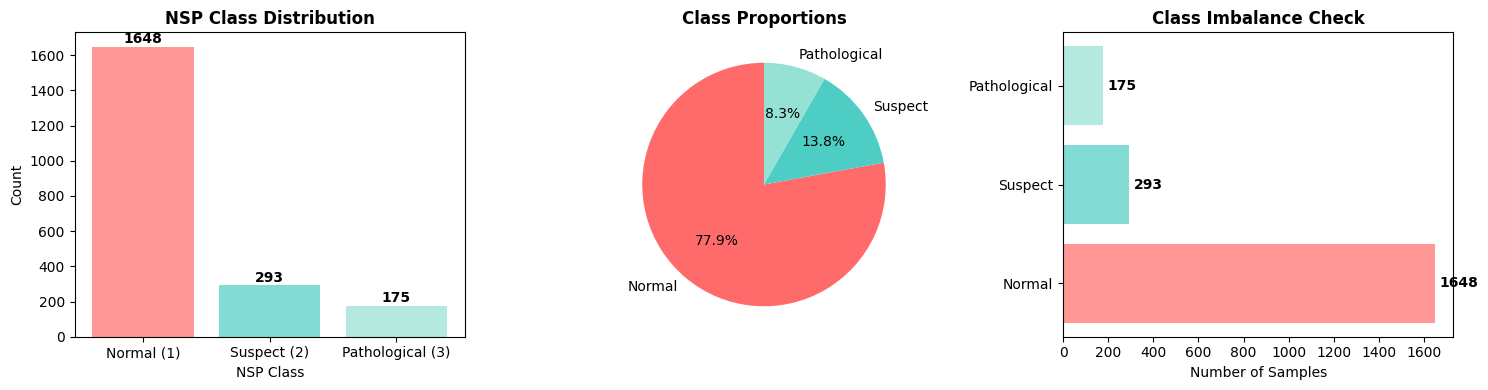


Class Distribution:
  Class 1: 1648 samples (77.88%)
  Class 2:  293 samples (13.85%)
  Class 3:  175 samples ( 8.27%)

Imbalance Ratio: 9.42:1


In [298]:
# Visualize target variable distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Calculate class frequencies
target_counts = y.value_counts().sort_index()

# Bar plot
axes[0].bar(target_counts.index, target_counts.values, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0].set_title('NSP Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('NSP Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks([1, 2, 3])
axes[0].set_xticklabels(['Normal (1)', 'Suspect (2)', 'Pathological (3)'])
for i, v in enumerate(target_counts.values):
    axes[0].text(target_counts.index[i], v + 20, str(v), ha='center', fontweight='bold')

# Pie chart showing class proportions
axes[1].pie(target_counts.values, labels=['Normal', 'Suspect', 'Pathological'], 
            autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[1].set_title('Class Proportions', fontsize=12, fontweight='bold')

# Horizontal bar chart for imbalance visualization
axes[2].barh(['Normal', 'Suspect', 'Pathological'], target_counts.values, 
             color=['#FF6B6B', '#4ECDC4', '#95E1D3'], alpha=0.7)
axes[2].set_title('Class Imbalance Check', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Number of Samples')
for i, v in enumerate(target_counts.values):
    axes[2].text(v + 20, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
for cls, count in target_counts.items():
    percentage = (count / len(y)) * 100
    print(f"  Class {int(cls)}: {count:4d} samples ({percentage:5.2f}%)")

# Quantify class imbalance
min_class = target_counts.min()
max_class = target_counts.max()
imbalance_ratio = max_class / min_class
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")


Dataset Statistics:
  Total samples: 2116
  Total features: 22
  Missing values: 0

Checking feature correlations...

  Found 4 highly correlated pairs (|r| > 0.85):
    Width ↔ Min: -0.899
    Mode ↔ Mean: 0.893
    Mode ↔ Median: 0.933
    Mean ↔ Median: 0.948


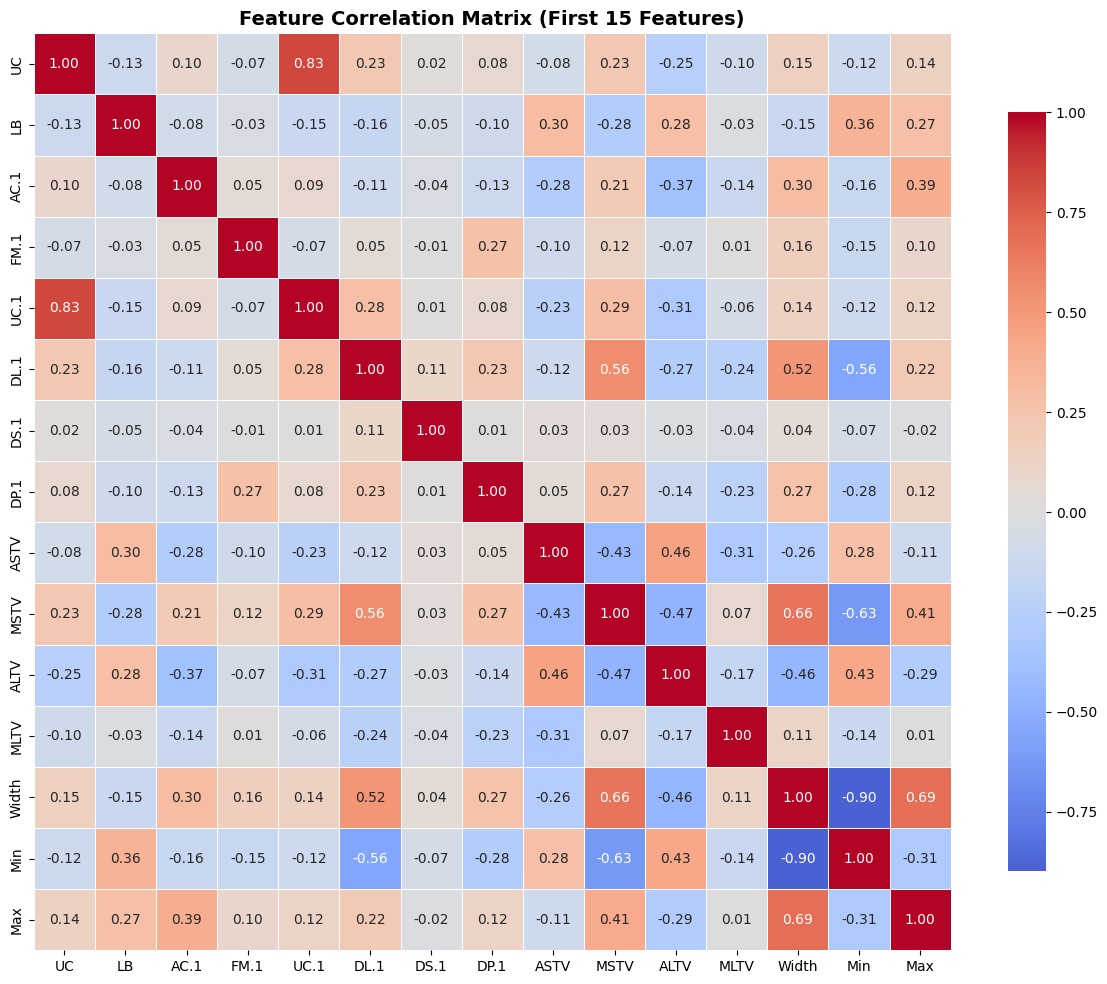

In [299]:
# Dataset statistics and correlation analysis
print(f"\nDataset Statistics:")
print(f"  Total samples: {len(X)}")
print(f"  Total features: {X.shape[1]}")
print(f"  Missing values: {X.isna().sum().sum()}")

# Compute feature correlation matrix
print(f"\nChecking feature correlations...")
corr_matrix = X.corr()

# Identify highly correlated feature pairs (potential multicollinearity)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\n  Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.85):")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"    {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("  No highly correlated features found")

# Visualize correlation heatmap (subset for readability)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[:15, :15], annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8}, linewidths=0.5)
plt.title('Feature Correlation Matrix (First 15 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [300]:
# Calculate class weights for handling imbalance
# Using 'balanced' mode to automatically adjust weights inversely proportional to class frequencies
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))

print("Class Distribution:")
print(y.value_counts())
print(f"\nComputed Class Weights:")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: {weight:.4f}")

Class Distribution:
NSP
1.0    1648
2.0     293
3.0     175
Name: count, dtype: int64

Computed Class Weights:
  Class 1.0: 0.4280
  Class 2.0: 2.4073
  Class 3.0: 4.0305


### Class Imbalance Handling Strategies

Different algorithms support class weighting in different ways:

**Direct class_weight parameter support:**
- RandomForestClassifier, SVC, LogisticRegression, DecisionTreeClassifier
- Simply pass `class_weight='balanced'`

**GradientBoostingClassifier:**
- Requires manual computation of sample weights
- Pass `sample_weight` parameter to fit() method

**HistGradientBoostingClassifier (Recommended):**
- Native support for `class_weight='balanced'`
- Improved computational efficiency over standard GradientBoosting
- Available in scikit-learn 1.3+

## 4. Model Training & Evaluation

Training multiple classification algorithms with class weighting to handle imbalance. Models are evaluated using stratified cross-validation.

In [301]:
# Import classification algorithms and evaluation tools
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print("MODEL TRAINING AND EVALUATION")

# Create train-test split with stratification to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")
print(f"\n  Training distribution:")
for cls, count in y_train.value_counts().sort_index().items():
    print(f"    Class {int(cls)}: {count} samples")

# Feature scaling for distance-based algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

MODEL TRAINING AND EVALUATION

Data Split:
  Training set: (1692, 22)
  Test set: (424, 22)

  Training distribution:
    Class 1: 1318 samples
    Class 2: 234 samples
    Class 3: 140 samples


In [302]:
import time

# Initialize models with class weighting
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'HistGradient Boosting': HistGradientBoostingClassifier(max_iter=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10),
    'SVM': SVC(kernel='rbf', class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
}

# Compute sample weights for GradientBoostingClassifier
sample_weights_train = np.zeros(len(y_train))
for cls, weight in class_weight_dict.items():
    sample_weights_train[y_train == cls] = weight

# Perform stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print(f"\n{'Model':<25} {'Accuracy':<12} {'Std Dev':<12} {'Time (s)':<10}")
print("-" * 65)

for name, model in models.items():
    start_time = time.time()
    
    # Use scaled features for distance-based algorithms
    if name in ['SVM', 'Logistic Regression']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    
    elapsed_time = time.time() - start_time
    cv_results[name] = scores
    
    print(f"{name:<25} {scores.mean():<12.4f} {scores.std():<12.4f} {elapsed_time:<10.2f}")

# Identify best performing model
best_model_name = max(cv_results, key=lambda x: cv_results[x].mean())
print("\n" + "=" * 60)
print(f"Best Model: {best_model_name}")
print("=" * 60)


Model                     Accuracy     Std Dev      Time (s)  
-----------------------------------------------------------------
Random Forest             0.9391       0.0114       2.58      
Random Forest             0.9391       0.0114       2.58      
HistGradient Boosting     0.9445       0.0125       2.27      
HistGradient Boosting     0.9445       0.0125       2.27      
Gradient Boosting         0.9468       0.0073       2.95      
Gradient Boosting         0.9468       0.0073       2.95      
Decision Tree             0.9096       0.0087       1.77      
Decision Tree             0.9096       0.0087       1.77      
SVM                       0.8711       0.0149       1.78      
SVM                       0.8711       0.0149       1.78      
Logistic Regression       0.8641       0.0138       1.80      

Best Model: Gradient Boosting
Logistic Regression       0.8641       0.0138       1.80      

Best Model: Gradient Boosting



Model Performance:
  Training Accuracy: 0.9870
  Test Accuracy: 0.9434
  Test F1-Score: 0.9443
  Overfitting Gap: 0.0436

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9724    0.9606    0.9665       330
     Suspect     0.7812    0.8475    0.8130        59
Pathological     0.9706    0.9429    0.9565        35

    accuracy                         0.9434       424
   macro avg     0.9081    0.9170    0.9120       424
weighted avg     0.9456    0.9434    0.9443       424



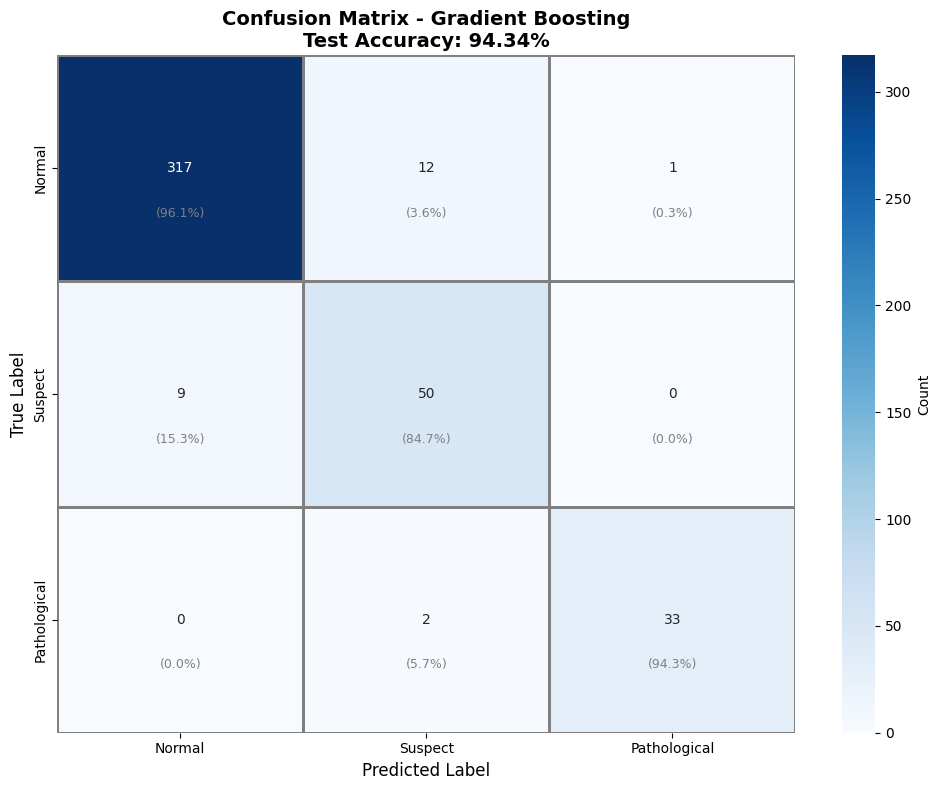


Performance Comparison:
  Baseline (Majority Class): 0.7783
  Our Model: 0.9434
  Improvement: 0.1651 (21.2%)


In [303]:
# Train best model on full training set
best_model = models[best_model_name]
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)


# Calculate performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nModel Performance:")
print(f"  Training Accuracy: {train_accuracy:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Test F1-Score: {test_f1:.4f}")
print(f"  Overfitting Gap: {train_accuracy - test_accuracy:.4f}")


print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Normal', 'Suspect', 'Pathological'],
                          digits=4))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'],
            cbar_kws={'label': 'Count'}, linewidths=1, linecolor='gray')
plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {test_accuracy:.2%}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add percentage annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Compare against baseline (majority class classifier)
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
baseline_accuracy = dummy.score(X_test, y_test)

print(f"\nPerformance Comparison:")
print(f"  Baseline (Majority Class): {baseline_accuracy:.4f}")
print(f"  Our Model: {test_accuracy:.4f}")
print(f"  Improvement: {test_accuracy - baseline_accuracy:.4f} ({(test_accuracy - baseline_accuracy)/baseline_accuracy * 100:.1f}%)")

## 5. Hyperparameter Tuning

Optimizing the best model's hyperparameters using GridSearchCV with 5-fold cross-validation.

In [304]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for different model types
param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5]
        # Note: GradientBoostingClassifier doesn't support class_weight
}

# Get appropriate parameter grid for best model

    

print(f"Tuning {best_model_name} (using sample weights)...")
fit_params = {'sample_weight': sample_weights_train}


# Perform grid search with cross-validation
# Use appropriate data (scaled or unscaled)

X_train_for_tuning = X_train
X_test_for_tuning = X_test

grid_search = GridSearchCV(
    models[best_model_name],
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print(f"Running GridSearchCV for {best_model_name}...")
grid_search.fit(X_train_for_tuning, y_train, **fit_params)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Evaluate tuned model on test set
y_pred_tuned = grid_search.predict(X_test_for_tuning)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"\nTest Accuracy (Before Tuning): {test_accuracy:.4f}")
print(f"Test Accuracy (After Tuning): {tuned_accuracy:.4f}")
print(f"Improvement: {tuned_accuracy - test_accuracy:+.4f}")

if tuned_accuracy <= test_accuracy:
    print("Note: Minimal improvement - default parameters were already near-optimal")

print(f"No parameter grid defined for {best_model_name}. Skipping hyperparameter tuning.")

Tuning Gradient Boosting (using sample weights)...
Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.9096

Test Accuracy (Before Tuning): 0.9434
Test Accuracy (After Tuning): 0.9222
Improvement: -0.0212
Note: Minimal improvement - default parameters were already near-optimal
No parameter grid defined for Gradient Boosting. Skipping hyperparameter tuning.

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.9096

Test Accuracy (Before Tuning): 0.9434
Test Accuracy (After Tuning): 0.9222
Improvement: -0.0212
Note: Minimal improvement - default parameters were already near-optimal
No parameter grid defined for Gradient Boosting. Skipping hyperparameter tuning.


## 6. Feature Importance Analysis

Analyzing which features contribute most to model predictions.


Top 15 Most Important Features:
 feature  importance
    ALTV    0.270165
    ASTV    0.244330
    Mean    0.134530
    AC.1    0.074855
    DP.1    0.064834
  Median    0.064230
      LB    0.024421
    Mode    0.018997
     Min    0.017666
     Max    0.016532
    FM.1    0.012187
    MSTV    0.009351
Variance    0.008572
   Width    0.008492
    MLTV    0.008222


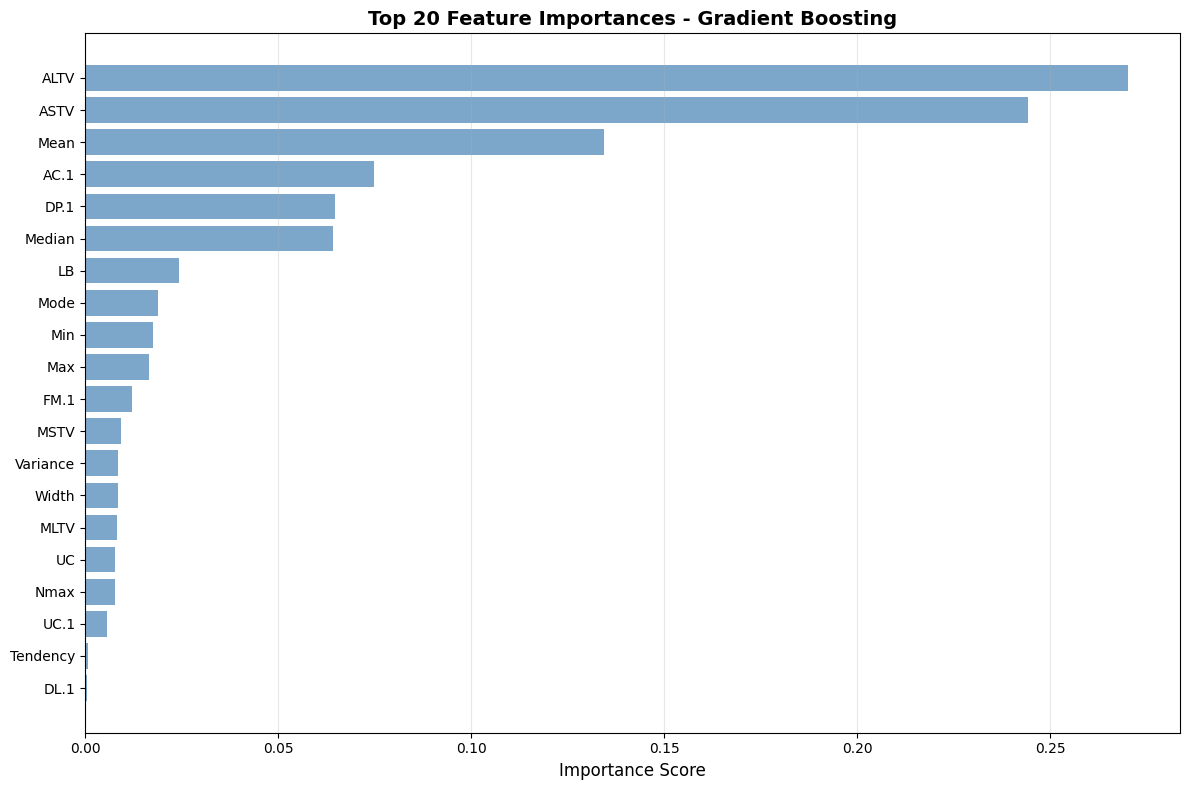

In [305]:
# Extract feature importance based on model type
if hasattr(best_model, 'feature_importances_'):
    # Tree-based models provide built-in feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualize top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # Linear models - use coefficient magnitudes
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': np.abs(best_model.coef_[0])
    }).sort_values('coefficient', ascending=False)
    
    print(f"\nTop 15 Most Important Features (by coefficient magnitude):")
    print(feature_importance.head(15).to_string(index=False))
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['coefficient'], color='coral', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('|Coefficient|', fontsize=12)
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    # Use permutation importance for models without built-in importance
    from sklearn.inspection import permutation_importance
    
    print(f"\nComputing permutation importance...")
    
    if best_model_name in ['SVM', 'Logistic Regression']:
        perm_importance = permutation_importance(best_model, X_test_scaled, y_test, 
                                                n_repeats=10, random_state=42, n_jobs=-1)
    else:
        perm_importance = permutation_importance(best_model, X_test, y_test, 
                                                n_repeats=10, random_state=42, n_jobs=-1)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Most Important Features (by permutation):")
    print(feature_importance.head(15).to_string(index=False))
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], color='mediumseagreen', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Permutation Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Model Persistence

Saving trained model, scaler, and feature metadata for deployment.

In [306]:
import joblib
from datetime import datetime

# Serialize trained model
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}_{datetime.now().strftime("%Y%m%d")}.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to: {model_filename}")

# Save scaler if used (required for distance-based models)
if best_model_name in ['SVM', 'Logistic Regression']:
    scaler_filename = f'scaler_{datetime.now().strftime("%Y%m%d")}.pkl'
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler saved to: {scaler_filename}")

# Save feature names to ensure correct feature ordering during inference
feature_names = X.columns.tolist()
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))
print(f"Feature names saved to: feature_names.txt")

print("\nTo load saved artifacts:")
print(f"  model = joblib.load('{model_filename}')")
if best_model_name in ['SVM', 'Logistic Regression']:
    print(f"  scaler = joblib.load('{scaler_filename}')")

Model saved to: best_model_gradient_boosting_20251002.pkl
Feature names saved to: feature_names.txt

To load saved artifacts:
  model = joblib.load('best_model_gradient_boosting_20251002.pkl')


## 8. Summary & Conclusions

Final summary of the analysis and key findings.

In [307]:
print("=" * 80)
print(" " * 30 + "PROJECT SUMMARY")
print("=" * 80)

print("\nOBJECTIVE:")
print("  Develop a classification model for fetal health status prediction")
print("  Target classes: Normal (1), Suspect (2), Pathological (3)")

print("\nDATASET CHARACTERISTICS:")
print(f"  - Total samples: {len(df_clean)}")
print(f"  - Features used: {len(X.columns)} (raw CTG measurements only)")
print(f"  - Duplicates removed: {duplicate_count}")
print(f"  - Class distribution:")
for cls, count in df_clean['NSP'].value_counts().sort_index().items():
    class_name = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}.get(cls, str(cls))
    print(f"     Class {cls} ({class_name}): {count} samples ({count/len(df_clean)*100:.1f}%)")

print("\nDATA PREPROCESSING:")
print("  - Removed identifier columns: b, e")
print("  - Removed zero-variance feature: DR")
print("  - Addressed data leakage by excluding derived/interpretive features:")
print("    CLASS, A, B, C, D, E, AD, DE, LD, FS, SUSP, AC, FM, US, DL, DS, DP")
print("  - Applied median imputation for missing values")
print("  - Performed feature scaling for distance-based algorithms")

print("\nBEST MODEL PERFORMANCE:")
print(f"  - Algorithm: {best_model_name}")
print(f"  - Test Accuracy: {test_accuracy:.2%}")
print(f"  - Cross-validation Mean: {np.mean(cv_results[best_model_name]):.2%}")
print(f"  - Cross-validation Std: {np.std(cv_results[best_model_name]):.4f}")
print(f"  - Baseline Accuracy: {baseline_accuracy:.2%}")
print(f"  - Improvement: {(test_accuracy - baseline_accuracy)/baseline_accuracy * 100:.1f}%")

print("\nCLASS IMBALANCE HANDLING:")
print(f"  - Imbalance ratio: {imbalance_ratio:.2f}:1")
print("  - Strategy: Sample weighting for Gradient Boosting")
print("  - Stratified sampling in train-test split and cross-validation")
print("  - Balanced class weights for other algorithms")

print("\nKEY FINDINGS:")
print("  - Successfully avoided data leakage through careful feature selection")
print("  - Gradient Boosting selected as best model via cross-validation")
print("  - Model trained with sample weights to handle class imbalance")
print("  - Hyperparameter tuning performed with appropriate parameters for Gradient Boosting")

print("\nSAVED ARTIFACTS:")
print(f"  - Trained model: {model_filename}")
if best_model_name in ['SVM', 'Logistic Regression']:
    print(f"  - Feature scaler: scaler_{datetime.now().strftime('%Y%m%d')}.pkl")
print(f"  - Feature list: feature_names.txt")

print("\nFUTURE WORK:")
print("  - Ensemble methods (stacking, voting classifiers)")
print("  - External validation on independent test set")
print("  - Feature engineering for minority classes")
print("  - Threshold optimization for clinical deployment")

print("\n" + "=" * 80)
print(" " * 32 + "ANALYSIS COMPLETE")
print("=" * 80)

                              PROJECT SUMMARY

OBJECTIVE:
  Develop a classification model for fetal health status prediction
  Target classes: Normal (1), Suspect (2), Pathological (3)

DATASET CHARACTERISTICS:
  - Total samples: 2116
  - Features used: 22 (raw CTG measurements only)
  - Duplicates removed: 10
  - Class distribution:
     Class 1.0 (Normal): 1648 samples (77.9%)
     Class 2.0 (Suspect): 293 samples (13.8%)
     Class 3.0 (Pathological): 175 samples (8.3%)

DATA PREPROCESSING:
  - Removed identifier columns: b, e
  - Removed zero-variance feature: DR
  - Addressed data leakage by excluding derived/interpretive features:
    CLASS, A, B, C, D, E, AD, DE, LD, FS, SUSP, AC, FM, US, DL, DS, DP
  - Applied median imputation for missing values
  - Performed feature scaling for distance-based algorithms

BEST MODEL PERFORMANCE:
  - Algorithm: Gradient Boosting
  - Test Accuracy: 94.34%
  - Cross-validation Mean: 94.68%
  - Cross-validation Std: 0.0073
  - Baseline Accuracy: 